TP2 IA+ / Naive Bayes/ Bouhadoun Lounis

In [39]:
import pandas as pd
import numpy as np
import re
import nltk
import math
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')

try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

from nltk.corpus import stopwords
nltk_stopwords = set(stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()

# Chargement des données


In [40]:

data = []
try:
    with open("SMSSpamCollection", "r", encoding="utf8") as f:
        for line in f:
            #
            split_line = line.strip().split('\t', 1)
            if len(split_line) == 2:
                label, message = split_line
                data.append((label, message))
except FileNotFoundError:
    print("Erreur: Le fichier 'SMSSpamCollection' n'a pas été trouvé.")
    print("Veuillez télécharger le dataset et le placer dans le répertoire du script.")
    
    exit()


df = pd.DataFrame(data, columns=["label","message"])

print("Aperçu du dataset :")
print(df.head())
print("\nNombre total de messages :", len(df))
print("\nRépartition des labels :")
print(df["label"].value_counts())


Aperçu du dataset :
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Nombre total de messages : 5574

Répartition des labels :
label
ham     4827
spam     747
Name: count, dtype: int64


# Séparation des Données en Ensembles d'Entraînement et de Test
Division du dataset en 80% pour l'entraînement et 20% pour le test.


In [41]:

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

print("\nTaille du jeu d'entraînement :", len(train_df))
print("Taille du jeu de test :", len(test_df))
print("\nRépartition des labels dans l'ensemble d'entraînement :")
print(train_df["label"].value_counts())
print("\nRépartition des labels dans l'ensemble de test :")
print(test_df["label"].value_counts())



Taille du jeu d'entraînement : 4459
Taille du jeu de test : 1115

Répartition des labels dans l'ensemble d'entraînement :
label
ham     3861
spam     598
Name: count, dtype: int64

Répartition des labels dans l'ensemble de test :
label
ham     966
spam    149
Name: count, dtype: int64


# Prétraitement des Messages SMS
Définition et application d'une fonction pour nettoyer et tokeniser le texte des messages.


In [42]:
def preprocess_text(text,
                    remove_stopwords=True,
                    do_stemming=True):
    """
    Nettoie et tokenize le texte d'un message.
    1. Enlève la ponctuation (sauf '!') et caractères non alphanumériques.
    2. Passe en minuscules.
    3. Tokenise.
    4. Retire les stopwords (optionnel).
    5. Applique le stemming (optionnel).
    """
    
    text = re.sub(r"[^a-zA-Z0-9\s!]", "", text)
    # minuscules
    text = text.lower()
    # tokenisation
    tokens = nltk.word_tokenize(text)
    # stopwords
    if remove_stopwords:
        tokens = [w for w in tokens if w not in nltk_stopwords]
    # stemming
    if do_stemming:
        tokens = [stemmer.stem(w) for w in tokens]
    return tokens

#dataframes
train_df = train_df.copy()
test_df = test_df.copy() 
train_df["tokens"] = train_df["message"].apply(preprocess_text)
test_df["tokens"] = test_df["message"].apply(preprocess_text)

print("\nExemple de tokens pour le premier message d'entraînement :")
print(train_df["tokens"].iloc[0])



Exemple de tokens pour le premier message d'entraînement :
['ok', 'way', 'home', 'hi', 'hi']


# Construction du Vocabulaire (Basé sur l'Ensemble d'Entraînement)
Comptage des fréquences de tokens et création d'un vocabulaire filtré.

In [43]:
# fréquences
token_counts = Counter()
for tokens in train_df["tokens"]:
    token_counts.update(set(tokens))

# tokens rares
min_count = 3
vocab = {token for token, count in token_counts.items() if count >= min_count}
vocab_list = sorted(list(vocab))

print(f"\nTaille initiale du vocabulaire (unique tokens train): {len(token_counts)}")
print(f"Taille du vocabulaire après filtrage (>= {min_count} occurrences) : {len(vocab)}")
print("\nExtrait du vocabulaire filtré :", vocab_list[:20])


Taille initiale du vocabulaire (unique tokens train): 7133
Taille du vocabulaire après filtrage (>= 3 occurrences) : 2076

Extrait du vocabulaire filtré : ['!', '0', '020603', '07xxxxxxxxx', '0800', '08000839402', '08000930705', '08001950382', '0808', '08452810073', '0870', '08701417012', '08707509020', '08712300220', '08712460324', '08715705022', '08717898035', '08718720201', '08718726270150gbpmtmsg18', '09050090044']


# Entraînement du Modèle Naïve Bayes (Vocabulaire Complet Filtré)
Calcul des probabilités a priori et conditionnelles nécessaires pour le modèle.

In [44]:
# séparation des messages d'entraînement par classe
train_spam = train_df[train_df["label"]=="spam"]
train_ham  = train_df[train_df["label"]=="ham"]
num_spam = len(train_spam)
num_ham  = len(train_ham)
num_total = num_spam + num_ham

# probaba a priori P(spam) et P(ham)
p_spam = num_spam / num_total
p_ham  = num_ham  / num_total
print(f"\nP(spam) = {p_spam:.4f}")
print(f"P(ham) = {p_ham:.4f}")

# tokens dans chaque classe
counts_spam = Counter()
counts_ham = Counter()


spam_token_sets = [set(tokens) & vocab for tokens in train_spam["tokens"]]
ham_token_sets = [set(tokens) & vocab for tokens in train_ham["tokens"]]

# maj
for token_set in spam_token_sets:
    counts_spam.update(token_set)
for token_set in ham_token_sets:
    counts_ham.update(token_set)


alpha = 1.0
prob_token_given_spam = {} # P(token=1 | spam)
prob_token_given_ham = {}  # P(token=1 | ham)

for token in vocab:
    prob_token_given_spam[token] = (counts_spam[token] + alpha) / (num_spam + 2 * alpha)
    prob_token_given_ham[token] = (counts_ham[token] + alpha) / (num_ham + 2 * alpha)

print(f"\nCalcul des probabilités conditionnelles terminé (avec lissage alpha={alpha}).")



P(spam) = 0.1341
P(ham) = 0.8659

Calcul des probabilités conditionnelles terminé (avec lissage alpha=1.0).


# Fonction de Prédiction Naïve Bayes


In [45]:

def predict_naive_bayes_bernoulli(tokens, return_scores=False):
    """
    Prédit la classe (spam/ham) d'un message tokenisé en utilisant le modèle Bernoulli NB.
    Calcule les log-probabilités a posteriori.
    """
    message_token_set = set(tokens) & vocab

    log_prob_spam = math.log(p_spam)
    log_prob_ham = math.log(p_ham)

    # TOUS les tokens du vocab
    for token in vocab:
        # token PRESENT
        if token in message_token_set:
            log_prob_spam += math.log(prob_token_given_spam[token])
            log_prob_ham += math.log(prob_token_given_ham[token])
        # token ABSENT

        else:
            # P(token=0 | classe) = 1 - P(token=1 | classe)
            log_prob_spam += math.log(1.0 - prob_token_given_spam[token])
            log_prob_ham += math.log(1.0 - prob_token_given_ham[token])

    
    prediction = "spam" if log_prob_spam > log_prob_ham else "ham"

    if return_scores:
        
        
        
        
        try:
            # cas log grand
            score_diff = log_prob_ham - log_prob_spam
            if score_diff > 700:
                 prob_spam_given_x = 0.0
            else:
                 prob_spam_given_x = 1 / (1 + math.exp(score_diff))
        except OverflowError:
             # exp() déborde : on attribue la probaba extrême
             prob_spam_given_x = 0.0 if log_prob_ham > log_prob_spam else 1.0

        return prediction, prob_spam_given_x
    else:
        return prediction

# Évaluation du Modèle (Vocabulaire Complet Filtré) sur l'Ensemble de Test


In [46]:

y_true = test_df["label"].values
y_pred_bernoulli = []
y_prob_bernoulli = []

for idx, row in test_df.iterrows():
    pred, prob = predict_naive_bayes_bernoulli(row["tokens"], return_scores=True)
    y_pred_bernoulli.append(pred)
    y_prob_bernoulli.append(prob)

y_pred_bernoulli = np.array(y_pred_bernoulli)

# matrice de confusion
TP = sum((y_true=="spam") & (y_pred_bernoulli=="spam"))
FN = sum((y_true=="spam") & (y_pred_bernoulli=="ham"))
FP = sum((y_true=="ham")  & (y_pred_bernoulli=="spam"))
TN = sum((y_true=="ham")  & (y_pred_bernoulli=="ham"))

print("\n--- Évaluation Bernoulli (Vocabulaire Complet Filtré) ---")
print("Matrice de confusion :")
print(f"          Pred: Spam | Pred: Ham")
print(f"True: Spam |   {TP:4d}   |   {FN:4d}")
print(f"True: Ham  |   {FP:4d}   |   {TN:4d}")

# métriques
accuracy  = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
error_rate = 1 - accuracy

print(f"\nAccuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f} (Proportion de prédictions 'spam' correctes)")
print(f"Recall    : {recall:.4f} (Proportion de vrais 'spam' détectés)")
print(f"F1-score  : {f1:.4f}")
print(f"Taux d'erreur: {error_rate:.4f}")

# Total Cost Ratio
cost_FP = 1  # Coût d'un Faux Positif (ham classé spam)
cost_FN = 10 # Coût d'un Faux Négatif (spam classé ham)
model_cost = cost_FP * FP + cost_FN * FN
#
#
baseline_cost = cost_FN * (TP + FN)
tcr = baseline_cost / model_cost if model_cost > 0 else float('inf') # /0
print(f"\nTCR (avec cost_FP={cost_FP}, cost_FN={cost_FN}) : {tcr:.3f} (Plus c'est élevé, mieux c'est)")



--- Évaluation Bernoulli (Vocabulaire Complet Filtré) ---
Matrice de confusion :
          Pred: Spam | Pred: Ham
True: Spam |    135   |     14
True: Ham  |      2   |    964

Accuracy  : 0.9857
Precision : 0.9854 (Proportion de prédictions 'spam' correctes)
Recall    : 0.9060 (Proportion de vrais 'spam' détectés)
F1-score  : 0.9441
Taux d'erreur: 0.0143

TCR (avec cost_FP=1, cost_FN=10) : 10.493 (Plus c'est élevé, mieux c'est)


# Graphe 1 : Matrice de Confusion (Vocabulaire Complet Filtré)

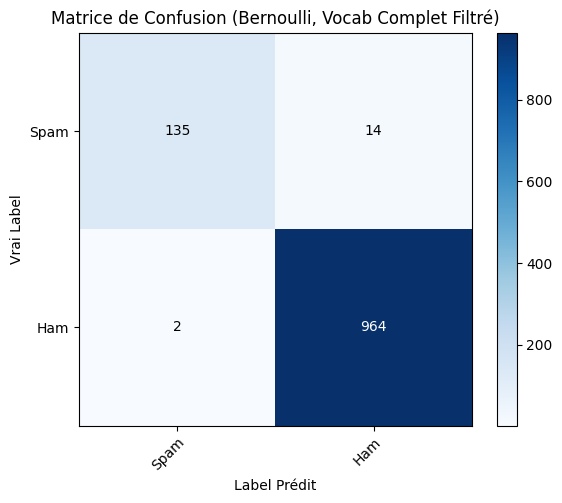

In [47]:
conf_matrix = np.array([[TP, FN], [FP, TN]])
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

classes = ['Spam', 'Ham']
ax.set(xticks=np.arange(conf_matrix.shape[1]),
       yticks=np.arange(conf_matrix.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Matrice de Confusion (Bernoulli, Vocab Complet Filtré)',
       ylabel='Vrai Label',
       xlabel='Label Prédit')

#
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

#
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

# Graphe 2 : Courbe ROC (Vocabulaire Complet Filtré)


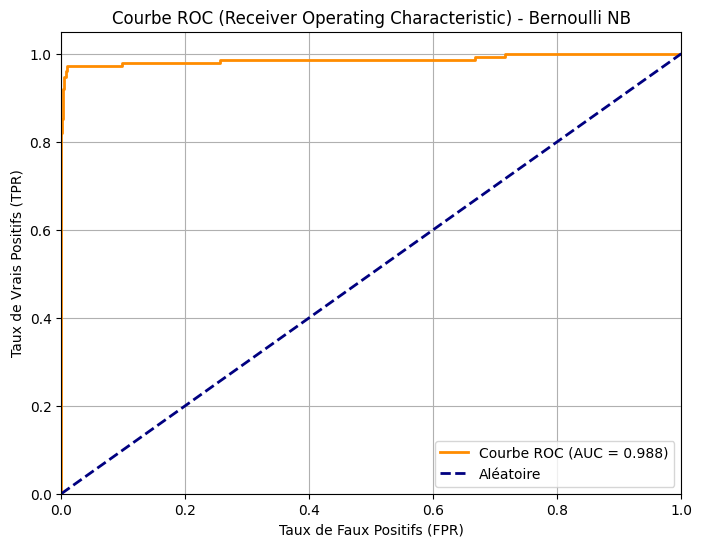


Aire sous la courbe ROC (AUC) : 0.9878


In [48]:
# conv des labels en binaire
y_true_bin = np.array([1 if label == "spam" else 0 for label in y_true])

fpr, tpr, thresholds = roc_curve(y_true_bin, y_prob_bernoulli)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC (Receiver Operating Characteristic) - Bernoulli NB')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nAire sous la courbe ROC (AUC) : {roc_auc:.4f}")


# Sélection de Caractéristiques par Information Mutuelle (MI)


In [49]:

def compute_mi_bernoulli(token, counts_spam, counts_ham, num_spam, num_ham, num_total):
    """
    Calcule l'Information Mutuelle pour un token donné dans un modèle Bernoulli.
    Utilise les comptages pré-calculés et le lissage alpha.
    """
    # P(token=1 | spam) et P(token=1 | ham)
    p_t1_spam = (counts_spam.get(token, 0) + alpha) / (num_spam + 2 * alpha)
    p_t1_ham  = (counts_ham.get(token, 0) + alpha) / (num_ham + 2 * alpha)

    # P(token=0 | spam) et P(token=0 | ham)
    p_t0_spam = 1.0 - p_t1_spam
    p_t0_ham  = 1.0 - p_t1_ham

    # P(spam) et P(ham)
    p_s = num_spam / num_total
    p_h = num_ham / num_total

    # P(token=1) et P(token=0)
    # P(t=1) = P(t=1|spam)P(spam) + P(t=1|ham)P(ham)
    p_t1 = p_t1_spam * p_s + p_t1_ham * p_h
    # P(t=0) = P(t=0|spam)P(spam) + P(t=0|ham)P(ham) = 1 - P(t=1)
    p_t0 = 1.0 - p_t1
    # ou sinon : p_t0 = p_t0_spam * p_s + p_t0_ham * p_h

    # Calcul de l'Information Mutuelle MI(Token, Classe)
    # MI = Σ_{t∈{0,1}} Σ_{c∈{spam,ham}} P(t,c) * log [ P(t,c) / (P(t) * P(c)) ]
    # P(t,c) = P(t|c) * P(c)

    mi = 0.0
    # pour (t=1, c=spam)
    if p_t1_spam > 0 and p_t1 > 0: # !! log(0)
      mi += (p_t1_spam * p_s) * math.log(p_t1_spam / p_t1)
    # pour (t=1, c=ham)
    if p_t1_ham > 0 and p_t1 > 0:
      mi += (p_t1_ham * p_h) * math.log(p_t1_ham / p_t1)
    # pour (t=0, c=spam)
    if p_t0_spam > 0 and p_t0 > 0:
      mi += (p_t0_spam * p_s) * math.log(p_t0_spam / p_t0)
    # pour (t=0, c=ham)
    if p_t0_ham > 0 and p_t0 > 0:
      mi += (p_t0_ham * p_h) * math.log(p_t0_ham / p_t0)

    return mi

#
mi_scores = []
for token in vocab:
    mi = compute_mi_bernoulli(token, counts_spam, counts_ham, num_spam, num_ham, num_total)
    mi_scores.append((token, mi))

# Mi DESCENDANT
mi_scores.sort(key=lambda x: x[1], reverse=True)

print("\n--- Top 20 Tokens par Information Mutuelle (MI) ---")
for token, score in mi_scores[:20]:
    p_spam_cond = prob_token_given_spam.get(token, 0)
    p_ham_cond = prob_token_given_ham.get(token, 0)
    print(f"{token:<10} MI={score:.4f}  P(t|spam)={p_spam_cond:.3f}  P(t|ham)={p_ham_cond:.3f}")



--- Top 20 Tokens par Information Mutuelle (MI) ---
call       MI=0.0605  P(t|spam)=0.433  P(t|ham)=0.056
txt        MI=0.0506  P(t|spam)=0.210  P(t|ham)=0.003
!          MI=0.0453  P(t|spam)=0.487  P(t|ham)=0.116
free       MI=0.0402  P(t|spam)=0.220  P(t|ham)=0.012
claim      MI=0.0396  P(t|spam)=0.147  P(t|ham)=0.000
mobil      MI=0.0334  P(t|spam)=0.152  P(t|ham)=0.004
prize      MI=0.0292  P(t|spam)=0.110  P(t|ham)=0.000
servic     MI=0.0233  P(t|spam)=0.098  P(t|ham)=0.001
repli      MI=0.0229  P(t|spam)=0.138  P(t|ham)=0.010
text       MI=0.0220  P(t|spam)=0.160  P(t|ham)=0.017
award      MI=0.0206  P(t|spam)=0.082  P(t|ham)=0.001
stop       MI=0.0200  P(t|spam)=0.125  P(t|ham)=0.009
urgent     MI=0.0199  P(t|spam)=0.082  P(t|ham)=0.001
cash       MI=0.0184  P(t|spam)=0.090  P(t|ham)=0.003
16         MI=0.0178  P(t|spam)=0.072  P(t|ham)=0.001
win        MI=0.0174  P(t|spam)=0.090  P(t|ham)=0.004
tc         MI=0.0172  P(t|spam)=0.072  P(t|ham)=0.001
tone       MI=0.0172  P(t|spa

# Évaluation avec Différentes Tailles de Vocabulaire (Basées sur MI)
Entraînement et évaluation du modèle en utilisant des sous-ensembles du vocabulaire (les k tokens avec la plus haute MI).


In [50]:

def train_eval_with_reduced_vocab(k, mi_scores, alpha=1.0):
    """
    Entraîne et évalue le modèle Bernoulli NB avec les k meilleurs tokens selon MI.
    Retourne un dictionnaire de métriques.
    """
    # meilleurs tokens
    if k > len(mi_scores):
        print(f"Attention : k={k} est plus grand que la taille du vocabulaire MI ({len(mi_scores)}). Utilisation de tous les tokens.")
        k = len(mi_scores)
    best_tokens = {token for token, score in mi_scores[:k]}

    # vocabulaire réduit seulemnt
    prob_spam_red = {}
    prob_ham_red = {}
    for token in best_tokens:
        #
        prob_spam_red[token] = prob_token_given_spam[token]
        prob_ham_red[token] = prob_token_given_ham[token]

    #prediction
    def predict_with_reduced_vocab(tokens, return_scores=False):
        message_token_set = set(tokens) & best_tokens
        log_pspam_red = math.log(p_spam)
        log_pham_red = math.log(p_ham)

        for token in best_tokens:
            if token in message_token_set:
                log_pspam_red += math.log(prob_spam_red[token])
                log_pham_red += math.log(prob_ham_red[token])
            else:
                log_pspam_red += math.log(1.0 - prob_spam_red[token])
                log_pham_red += math.log(1.0 - prob_ham_red[token])

        pred = "spam" if log_pspam_red > log_pham_red else "ham"

        if return_scores:
             try:
                 score_diff = log_pham_red - log_pspam_red
                 if score_diff > 700:
                      prob_spam_given_x_red = 0.0
                 else:
                      prob_spam_given_x_red = 1 / (1 + math.exp(score_diff))
             except OverflowError:
                 prob_spam_given_x_red = 0.0 if log_pham_red > log_pspam_red else 1.0
             return pred, prob_spam_given_x_red
        return pred

    # eval sur tout le test
    y_pred_red = []
    y_prob_red = []
    for idx, row in test_df.iterrows():
        pred, prob = predict_with_reduced_vocab(row["tokens"], return_scores=True)
        y_pred_red.append(pred)
        y_prob_red.append(prob)

    y_pred_red = np.array(y_pred_red)
    TP_red = sum((y_true == "spam") & (y_pred_red == "spam"))
    FN_red = sum((y_true == "spam") & (y_pred_red == "ham"))
    FP_red = sum((y_true == "ham") & (y_pred_red == "spam"))
    TN_red = sum((y_true == "ham") & (y_pred_red == "ham"))

    # métriques
    accuracy_red = (TP_red + TN_red) / len(y_true)
    precision_red = TP_red / (TP_red + FP_red) if (TP_red + FP_red) > 0 else 0
    recall_red = TP_red / (TP_red + FN_red) if (TP_red + FN_red) > 0 else 0
    f1_red = 2 * precision_red * recall_red / (precision_red + recall_red) if (precision_red + recall_red) > 0 else 0

    # TCR
    model_cost_red = cost_FP * FP_red + cost_FN * FN_red
    #
    tcr_red = baseline_cost / model_cost_red if model_cost_red > 0 else float('inf')

    # ROC AUC
    y_true_bin = np.array([1 if y == "spam" else 0 for y in y_true])
    fpr_red, tpr_red, _ = roc_curve(y_true_bin, y_prob_red)
    roc_auc_red = auc(fpr_red, tpr_red)

    print(f"\n--- Évaluation Bernoulli (Vocabulaire Réduit k={k}) ---")
    print(f"TP={TP_red}, FN={FN_red}, FP={FP_red}, TN={TN_red}")
    print(f"Accuracy={accuracy_red:.4f}, Precision={precision_red:.4f}, Recall={recall_red:.4f}, F1={f1_red:.4f}")
    print(f"TCR={tcr_red:.3f}, ROC AUC={roc_auc_red:.4f}")

    return {
        'vocab_size': k,
        'accuracy': accuracy_red,
        'precision': precision_red,
        'recall': recall_red,
        'f1': f1_red,
        'tcr': tcr_red,
        'roc_auc': roc_auc_red,
        'fpr': fpr_red,
        'tpr': tpr_red
    }

# différentes tailles de vocab
vocab_sizes_to_test = [50, 100, 200, 500, 1000, len(vocab)]
results_by_size = []

for k in vocab_sizes_to_test:
    #
    if k == len(vocab):
        print("\n--- Utilisation des résultats Bernoulli (Vocabulaire Complet Filtré) ---")
        results_by_size.append({
             'vocab_size': k, 'accuracy': accuracy, 'precision': precision,
             'recall': recall, 'f1': f1, 'tcr': tcr, 'roc_auc': roc_auc,
             'fpr': fpr, 'tpr': tpr
        })
    else:
        result = train_eval_with_reduced_vocab(k, mi_scores)
        results_by_size.append(result)



--- Évaluation Bernoulli (Vocabulaire Réduit k=50) ---
TP=127, FN=22, FP=7, TN=959
Accuracy=0.9740, Precision=0.9478, Recall=0.8523, F1=0.8975
TCR=6.564, ROC AUC=0.9803

--- Évaluation Bernoulli (Vocabulaire Réduit k=100) ---
TP=129, FN=20, FP=6, TN=960
Accuracy=0.9767, Precision=0.9556, Recall=0.8658, F1=0.9085
TCR=7.233, ROC AUC=0.9842

--- Évaluation Bernoulli (Vocabulaire Réduit k=200) ---
TP=133, FN=16, FP=2, TN=964
Accuracy=0.9839, Precision=0.9852, Recall=0.8926, F1=0.9366
TCR=9.198, ROC AUC=0.9870

--- Évaluation Bernoulli (Vocabulaire Réduit k=500) ---
TP=131, FN=18, FP=3, TN=963
Accuracy=0.9812, Precision=0.9776, Recall=0.8792, F1=0.9258
TCR=8.142, ROC AUC=0.9899

--- Évaluation Bernoulli (Vocabulaire Réduit k=1000) ---
TP=134, FN=15, FP=1, TN=965
Accuracy=0.9857, Precision=0.9926, Recall=0.8993, F1=0.9437
TCR=9.868, ROC AUC=0.9874

--- Utilisation des résultats Bernoulli (Vocabulaire Complet Filtré) ---


# Visualisation Comparative des Résultats (Selon Taille Vocabulaire)

Graphe 3 : Comparaison des Courbes ROC
Superposition des courbes ROC pour les différentes tailles de vocabulaire testées.

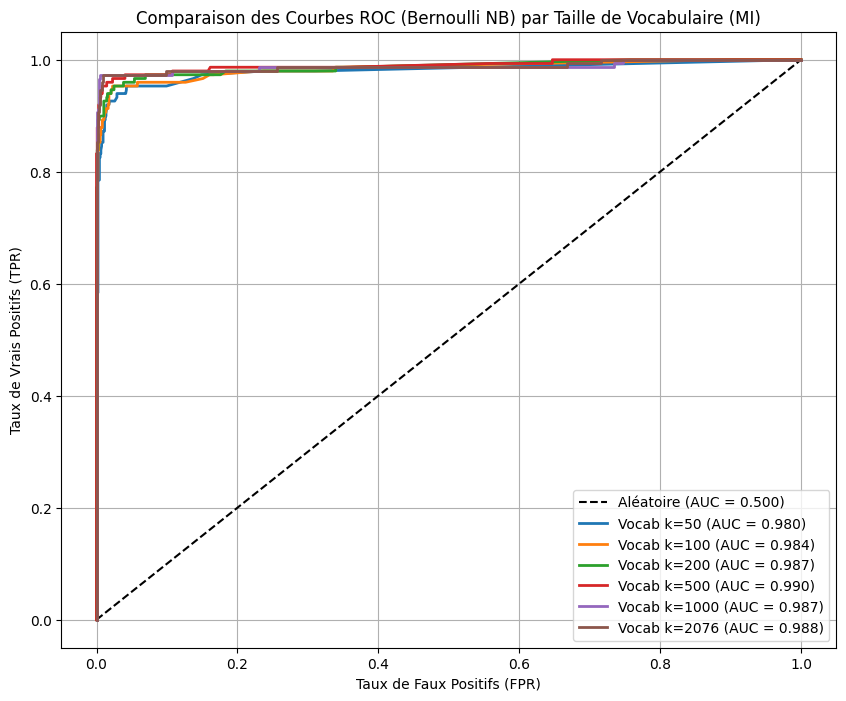

In [51]:
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.500)')

# Tri
results_by_size.sort(key=lambda x: x['vocab_size'])

for result in results_by_size:
    label = f"Vocab k={result['vocab_size']} (AUC = {result['roc_auc']:.3f})"
    #
    plt.plot(result['fpr'], result['tpr'], lw=2, label=label)

plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Comparaison des Courbes ROC (Bernoulli NB) par Taille de Vocabulaire (MI)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Graphe 4 : Évolution des Métriques vs Taille du Vocabulaire
Visualisation de l'accuracy, precision, recall, F1-score et TCR en fonction de la taille du vocabulaire sélectionné par MI.

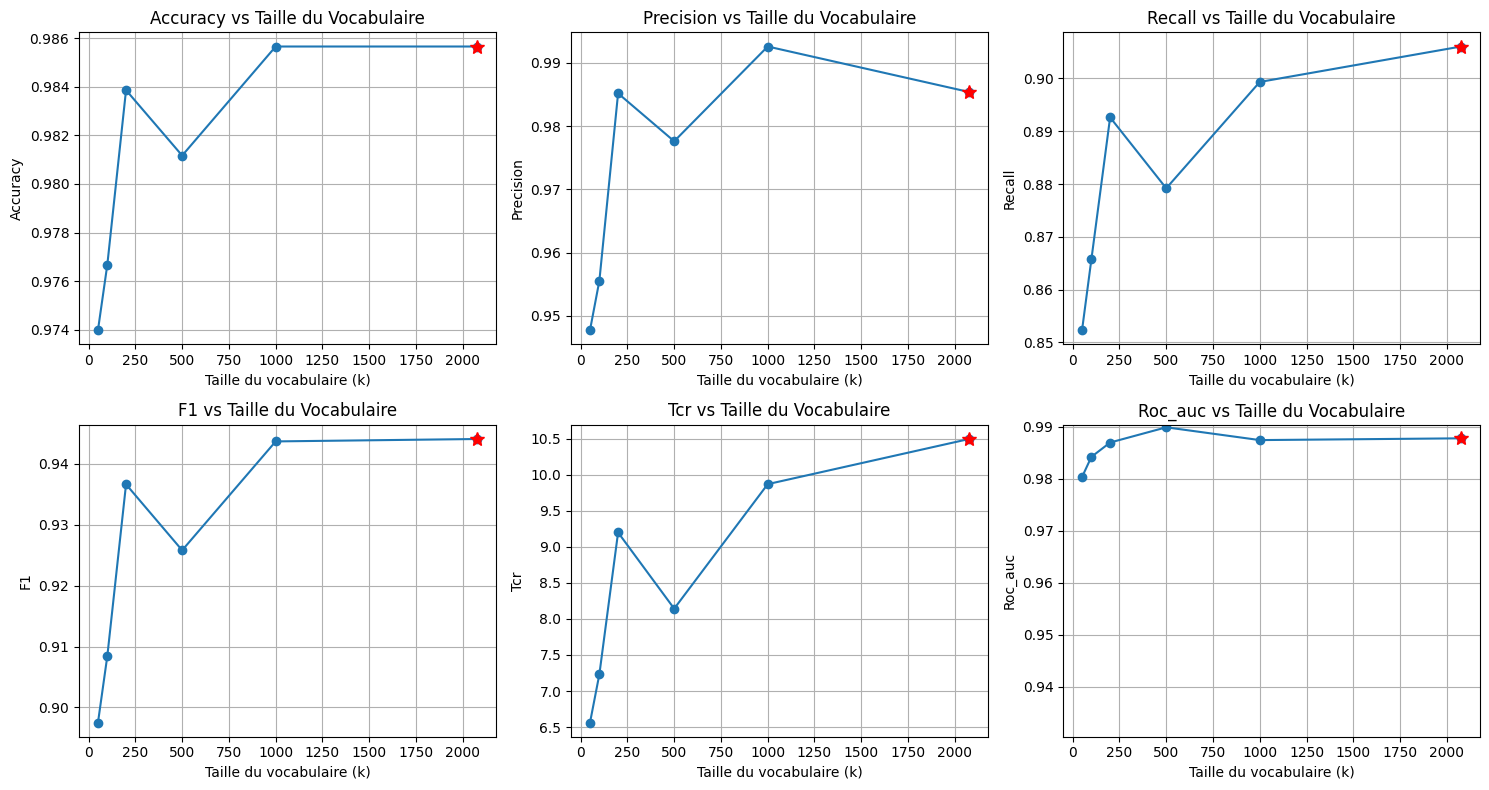

In [52]:
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'tcr', 'roc_auc']
num_metrics = len(metrics_to_plot)
num_cols = 3
num_rows = (num_metrics + num_cols - 1) // num_cols

plt.figure(figsize=(15, num_rows * 4))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(num_rows, num_cols, i + 1)
    sizes = [r['vocab_size'] for r in results_by_size]
    values = [r[metric] for r in results_by_size]

    plt.plot(sizes, values, 'o-', label=metric.capitalize())
    #
    full_vocab_size = len(vocab)
    if full_vocab_size in sizes:
         idx = sizes.index(full_vocab_size)
         plt.plot(sizes[idx], values[idx], 'r*', markersize=10, label='Vocab Complet')


    plt.xlabel('Taille du vocabulaire (k)')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} vs Taille du Vocabulaire')
    plt.grid(True)
    if metric == 'tcr':
        #
        #
        pass #
    if metric == 'roc_auc':
         plt.ylim(bottom=max(0, min(values) - 0.05))


plt.tight_layout()
plt.show()

# Implémentation et Évaluation d'un Modèle Naïve Bayes Multinomial
Comparaison avec le modèle Bernoulli en utilisant une approche Multinomiale NB.

In [53]:
counts_spam_multi = Counter()
counts_ham_multi = Counter()
total_spam_tokens = 0 # spams
total_ham_tokens = 0  # hams

#
for tokens in train_spam["tokens"]:
    filtered_tokens = [t for t in tokens if t in vocab] # filtrage
    counts_spam_multi.update(filtered_tokens)
    total_spam_tokens += len(filtered_tokens)

for tokens in train_ham["tokens"]:
    filtered_tokens = [t for t in tokens if t in vocab] # filtrage
    counts_ham_multi.update(filtered_tokens)
    total_ham_tokens += len(filtered_tokens)

print(f"\nNombre total de tokens (filtrés) dans les spams (train): {total_spam_tokens}")
print(f"Nombre total de tokens (filtrés) dans les hams (train): {total_ham_tokens}")

# P(token | classe) Multinomial
# 
alpha_multi = 1.0
vocab_size = len(vocab)

prob_token_given_spam_multi = {}
prob_token_given_ham_multi = {}

for token in vocab:
    prob_token_given_spam_multi[token] = (counts_spam_multi[token] + alpha_multi) / (total_spam_tokens + alpha_multi * vocab_size)
    prob_token_given_ham_multi[token] = (counts_ham_multi[token] + alpha_multi) / (total_ham_tokens + alpha_multi * vocab_size)

print(f"\nCalcul des probabilités conditionnelles Multinomial terminé (alpha={alpha_multi}).")



Nombre total de tokens (filtrés) dans les spams (train): 8721
Nombre total de tokens (filtrés) dans les hams (train): 28027

Calcul des probabilités conditionnelles Multinomial terminé (alpha=1.0).


# Fonction de Prédiction Naïve Bayes Multinomial


In [54]:

def predict_naive_bayes_multinomial(tokens, return_scores=False):
    """
    Prédit la classe (spam/ham) en utilisant le modèle Multinomial NB.
    """
    # filtrage des tokens
    message_tokens_in_vocab = [t for t in tokens if t in vocab]

    # initialisation des log-probabilités
    log_prob_spam_multi = math.log(p_spam)
    log_prob_ham_multi = math.log(p_ham)

    # ajout des log-probabilités pour chaque token
    for token in message_tokens_in_vocab:
        log_prob_spam_multi += math.log(prob_token_given_spam_multi[token])
        log_prob_ham_multi += math.log(prob_token_given_ham_multi[token])

    # Prédiction
    prediction = "spam" if log_prob_spam_multi > log_prob_ham_multi else "ham"

    if return_scores:
        # P(spam | message)
        try:
            score_diff = log_prob_ham_multi - log_prob_spam_multi
            if score_diff > 700:
                 prob_spam_given_x_multi = 0.0
            else:
                 prob_spam_given_x_multi = 1 / (1 + math.exp(score_diff))
        except OverflowError:
            prob_spam_given_x_multi = 0.0 if log_prob_ham_multi > log_prob_spam_multi else 1.0
        return prediction, prob_spam_given_x_multi
    else:
        return prediction


# Évaluation du Modèle Multinomial

In [55]:
y_pred_multi = []
y_prob_multi = [] #ROC

for idx, row in test_df.iterrows():
    pred, prob = predict_naive_bayes_multinomial(row["tokens"], return_scores=True)
    y_pred_multi.append(pred)
    y_prob_multi.append(prob)

y_pred_multi = np.array(y_pred_multi)

# confusion
TP_multi = sum((y_true=="spam") & (y_pred_multi=="spam"))
FN_multi = sum((y_true=="spam") & (y_pred_multi=="ham"))
FP_multi = sum((y_true=="ham")  & (y_pred_multi=="spam"))
TN_multi = sum((y_true=="ham")  & (y_pred_multi=="ham"))

print("\n--- Évaluation Naïve Bayes Multinomial (Vocabulaire Complet Filtré) ---")
print("Matrice de confusion :")
print(f"          Pred: Spam | Pred: Ham")
print(f"True: Spam |   {TP_multi:4d}   |   {FN_multi:4d}")
print(f"True: Ham  |   {FP_multi:4d}   |   {TN_multi:4d}")

# Métriques
accuracy_multi  = (TP_multi + TN_multi) / len(y_true)
precision_multi = TP_multi / (TP_multi + FP_multi) if (TP_multi + FP_multi) > 0 else 0
recall_multi    = TP_multi / (TP_multi + FN_multi) if (TP_multi + FN_multi) > 0 else 0
f1_multi        = 2 * precision_multi * recall_multi / (precision_multi + recall_multi) if (precision_multi + recall_multi) > 0 else 0
error_rate_multi = 1 - accuracy_multi

print(f"\nAccuracy  : {accuracy_multi:.4f}")
print(f"Precision : {precision_multi:.4f}")
print(f"Recall    : {recall_multi:.4f}")
print(f"F1-score  : {f1_multi:.4f}")
print(f"Taux d'erreur: {error_rate_multi:.4f}")

# TCR
model_cost_multi = cost_FP * FP_multi + cost_FN * FN_multi
#  cost
tcr_multi = baseline_cost / model_cost_multi if model_cost_multi > 0 else float('inf')
print(f"\nTCR (cost_FP={cost_FP}, cost_FN={cost_FN}) : {tcr_multi:.3f}")

# ROC AUC
fpr_multi, tpr_multi, _ = roc_curve(y_true_bin, y_prob_multi)
roc_auc_multi = auc(fpr_multi, tpr_multi)
print(f"ROC AUC : {roc_auc_multi:.4f}")



--- Évaluation Naïve Bayes Multinomial (Vocabulaire Complet Filtré) ---
Matrice de confusion :
          Pred: Spam | Pred: Ham
True: Spam |    136   |     13
True: Ham  |      9   |    957

Accuracy  : 0.9803
Precision : 0.9379
Recall    : 0.9128
F1-score  : 0.9252
Taux d'erreur: 0.0197

TCR (cost_FP=1, cost_FN=10) : 10.719
ROC AUC : 0.9768


# Graphe 5 : Comparaison Finale des Courbes ROC (Bernoulli vs Multinomial)
Superposition des courbes ROC pour le meilleur modèle Bernoulli (vocabulaire complet et/ou réduit optimal) et le modèle Multinomial.

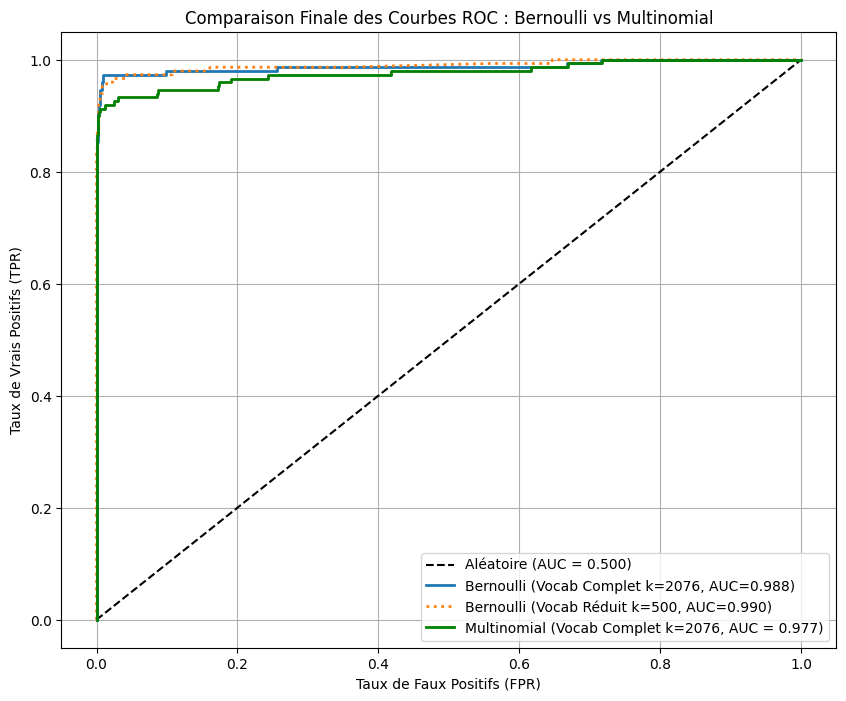

In [56]:

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.500)')

# meilleur resultat BR sur AUC
best_bernoulli_result = max(results_by_size, key=lambda x: x['roc_auc'])
# 
bernoulli_k500 = next((r for r in results_by_size if r['vocab_size'] == 500), None)
# vocab complet
bernoulli_full = next((r for r in results_by_size if r['vocab_size'] == len(vocab)), None)


#
if bernoulli_full:
    plt.plot(bernoulli_full['fpr'], bernoulli_full['tpr'], lw=2,
             label=f"Bernoulli (Vocab Complet k={bernoulli_full['vocab_size']}, AUC={bernoulli_full['roc_auc']:.3f})")

# vocab réduit
if bernoulli_k500:
    plt.plot(bernoulli_k500['fpr'], bernoulli_k500['tpr'], lw=2, linestyle=':',
             label=f"Bernoulli (Vocab Réduit k=500, AUC={bernoulli_k500['roc_auc']:.3f})")

# Multinomial
plt.plot(fpr_multi, tpr_multi, lw=2, color='green',
         label=f'Multinomial (Vocab Complet k={len(vocab)}, AUC = {roc_auc_multi:.3f})')


plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Comparaison Finale des Courbes ROC : Bernoulli vs Multinomial')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Tableau Comparatif Final des Performances


In [57]:
print("\n--- Tableau Récapitulatif des Performances ---")
print(f"{'Modèle':<30} | {'Vocab Size':<12} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'TCR':<10} | {'AUC':<10}")
print("-" * 105)

#
for r in sorted(results_by_size, key=lambda x: x['vocab_size']):
    model_name = f"Bernoulli NB"
    print(f"{model_name:<30} | {r['vocab_size']:<12} | {r['accuracy']:.4f} | {r['precision']:.4f} | {r['recall']:.4f} | {r['f1']:.4f} | {r['tcr']:.3f} | {r['roc_auc']:.4f}")

print("-" * 105)
#
model_name_multi = "Multinomial NB"
print(f"{model_name_multi:<30} | {len(vocab):<12} | {accuracy_multi:.4f} | {precision_multi:.4f} | {recall_multi:.4f} | {f1_multi:.4f} | {tcr_multi:.3f} | {roc_auc_multi:.4f}")
print("-" * 105)


--- Tableau Récapitulatif des Performances ---
Modèle                         | Vocab Size   | Accuracy   | Precision  | Recall     | F1-Score   | TCR        | AUC       
---------------------------------------------------------------------------------------------------------
Bernoulli NB                   | 50           | 0.9740 | 0.9478 | 0.8523 | 0.8975 | 6.564 | 0.9803
Bernoulli NB                   | 100          | 0.9767 | 0.9556 | 0.8658 | 0.9085 | 7.233 | 0.9842
Bernoulli NB                   | 200          | 0.9839 | 0.9852 | 0.8926 | 0.9366 | 9.198 | 0.9870
Bernoulli NB                   | 500          | 0.9812 | 0.9776 | 0.8792 | 0.9258 | 8.142 | 0.9899
Bernoulli NB                   | 1000         | 0.9857 | 0.9926 | 0.8993 | 0.9437 | 9.868 | 0.9874
Bernoulli NB                   | 2076         | 0.9857 | 0.9854 | 0.9060 | 0.9441 | 10.493 | 0.9878
---------------------------------------------------------------------------------------------------------
Multinomial NB       